extraire le contenu de votre fichier ZIP.**texte en gras**

In [13]:
!pip install -U tensorflow matplotlib

In [14]:
import os, zipfile, glob, shutil
from pathlib import Path

# === Chemin du zip ===
# Colab: mets ton zip dans /content/
# Local: mets le zip dans le dossier du notebook
ZIP_PATH = "/content/dataset.zip"  # adapte si besoin (ex: "/content/dataset.zip")

# === Dossier d'extraction ===
DATA_ROOT = Path("data_extracted")
DATA_ROOT.mkdir(exist_ok=True)

# Décompression
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(DATA_ROOT)

print("OK: extraction terminée dans:", DATA_ROOT.resolve())

# Chercher automatiquement train/test ou train/validation
all_dirs = [p for p in DATA_ROOT.rglob("*") if p.is_dir()]
train_candidates = [p for p in all_dirs if p.name.lower() == "train"]
test_candidates  = [p for p in all_dirs if p.name.lower() in ["test", "val", "valid", "validation"]]

if not train_candidates or not test_candidates:
    print("Structure non détectée automatiquement.")
    print("Dossiers trouvés (exemples):", all_dirs[:10])
    raise ValueError("Impossible de trouver 'train' et 'test/validation' dans le ZIP.")

train_dir = train_candidates[0]
val_dir = test_candidates[0]

print("Train dir:", train_dir)
print("Val/Test dir:", val_dir)

# Afficher les classes
classes = sorted([p.name for p in train_dir.iterdir() if p.is_dir()])
print("Classes:", classes)


OK: extraction terminée dans: /content/data_extracted
Train dir: data_extracted/v_data/train
Val/Test dir: data_extracted/v_data/test
Classes: ['cars', 'planes']


In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Paramètres images
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 16
EPOCHS = 10

# Pour reproductibilité
tf.random.set_seed(42)


Générateurs d’images:***texte en gras*

Entraînement du **modèle**

In [4]:
train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",   # 2 classes => categorical OK (one-hot)
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Version B (sans augmentation) — “rescale **uniquement”**

In [6]:
train_datagen_noaug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen_noaug = train_datagen_noaug.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)


Found 400 images belonging to 2 classes.


Modèle de base (comme ton CNN) + entraînement + courbes **résultats**

In [7]:
def build_baseline_model(num_classes: int):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

baseline = build_baseline_model(train_gen_aug.num_classes)
baseline.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,690 (49.36 MB)

 Trainable params: 12,938,690 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Entraîner 2 fois et comparer (augmentation vs pas augmentation)**texte en gras**

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5582 - loss: 1.4765 - val_accuracy: 0.8600 - val_loss: 0.3198
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8583 - loss: 0.3834 - val_accuracy: 0.8400 - val_loss: 0.3171
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8978 - loss: 0.2908 - val_accuracy: 0.8900 - val_loss: 0.3139
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8780 - loss: 0.2809 - val_accuracy: 0.8200 - val_loss: 0.4437
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8838 - loss: 0.2924 - val_accuracy: 0.8400 - val_loss: 0.4006
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8982 - loss: 0.2377 - val_accuracy: 0.8600 - val_loss: 0.3307
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9369 - loss: 0.1410 - val_accuracy: 0.9300 - val_loss: 0.2439
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9366 - loss: 0.1459 - val_accuracy: 0.9300 - val_loss:

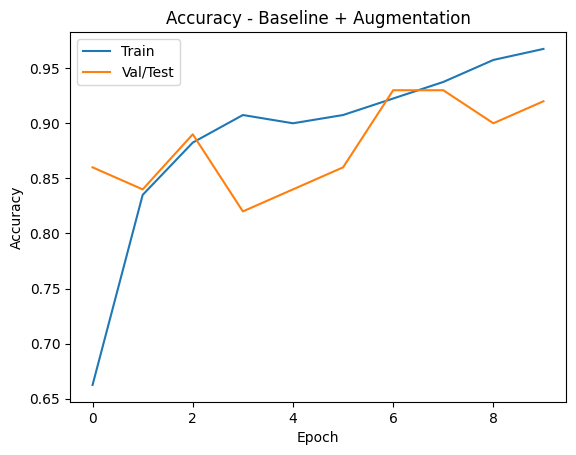

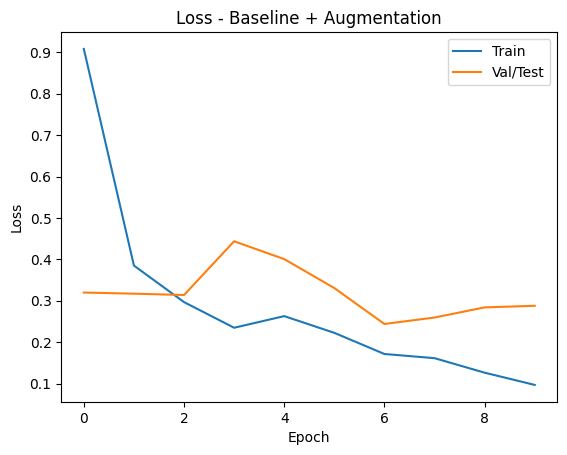

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4825 - loss: 1.3283 - val_accuracy: 0.8800 - val_loss: 0.5327
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7210 - loss: 0.5434 - val_accuracy: 0.8700 - val_loss: 0.3281
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8553 - loss: 0.3392 - val_accuracy: 0.8600 - val_loss: 0.3380
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9279 - loss: 0.1888 - val_accuracy: 0.8000 - val_loss: 0.5506
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9397 - loss: 0.2104 - val_accuracy: 0.8300 - val_loss: 0.4933
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9706 - loss: 0.1036 - val_accuracy: 0.8900 - val_loss: 0.4884
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9878 - loss: 0.0321 - val_accuracy: 0.8400 - val_loss: 0.5427
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9912 - loss: 0.0270 - val_accuracy: 0.8600 - val_loss:

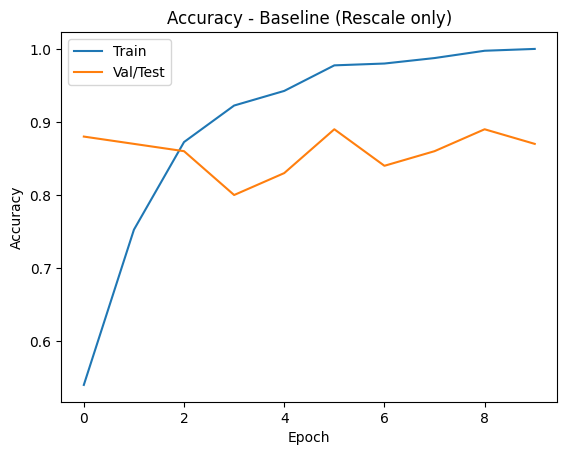

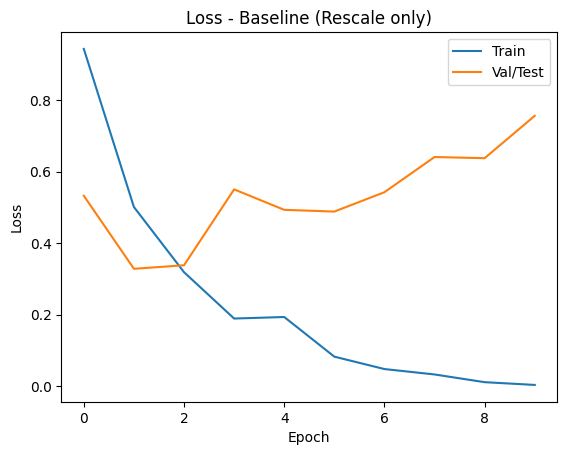

=== Comparaison Exercice 3 ===
AUG  : val_acc=0.9200  val_loss=0.2879
NOAUG: val_acc=0.8700  val_loss=0.7567


In [8]:
def train_and_plot(model, train_gen, val_gen, title):
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen
    )

    # Courbes
    plt.figure()
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title(f"Accuracy - {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Val/Test"])
    plt.show()

    plt.figure()
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title(f"Loss - {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Val/Test"])
    plt.show()

    # Évaluation finale
    loss, acc = model.evaluate(val_gen, verbose=0)
    return history, acc, loss

# A) Avec augmentation
baseline_aug = build_baseline_model(train_gen_aug.num_classes)
hist_aug, acc_aug, loss_aug = train_and_plot(baseline_aug, train_gen_aug, val_gen, "Baseline + Augmentation")

# B) Sans augmentation
baseline_noaug = build_baseline_model(train_gen_noaug.num_classes)
hist_noaug, acc_noaug, loss_noaug = train_and_plot(baseline_noaug, train_gen_noaug, val_gen, "Baseline (Rescale only)")

print("=== Comparaison Exercice 3 ===")
print(f"AUG  : val_acc={acc_aug:.4f}  val_loss={loss_aug:.4f}")
print(f"NOAUG: val_acc={acc_noaug:.4f}  val_loss={loss_noaug:.4f}")


In [9]:
train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",   # 2 classes => categorical OK (one-hot)
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Nouvelle architecture CNN  + Dropout + **performances**

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,914 (433.26 KB)

 Trainable params: 110,466 (431.51 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6675 - loss: 0.6703

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.6692 - loss: 0.6679 - val_accuracy: 0.5000 - val_loss: 0.7379
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.7637 - loss: 0.4837 - val_accuracy: 0.5000 - val_loss: 0.9104
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.7734 - loss: 0.5134 - val_accuracy: 0.5000 - val_loss: 1.0648
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7600 - loss: 0.4895 - val_accuracy: 0.5000 - val_loss: 1.0998
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.7314 - loss: 0.5260 - val_accuracy: 0.5000 - val_loss: 1.3670
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.7556 - loss: 0.4885 - val_accuracy: 0.5000 - val_loss: 1.4553
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.7443 - loss: 0.4800 - val_accuracy: 0.5000 - val_loss: 1.5646
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.7934 - loss: 0.4437 - val_accuracy: 0.5000 - val_loss: 1.8653
Epo

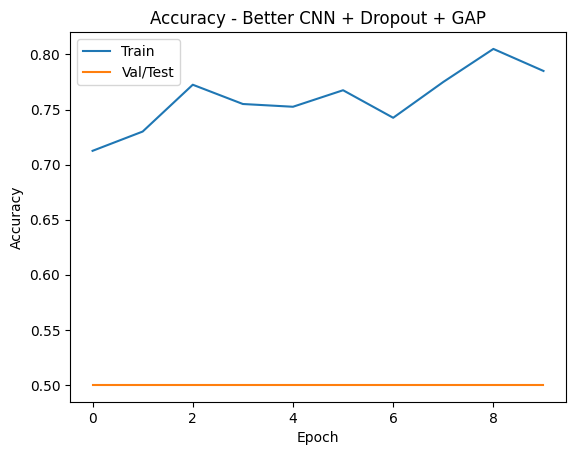

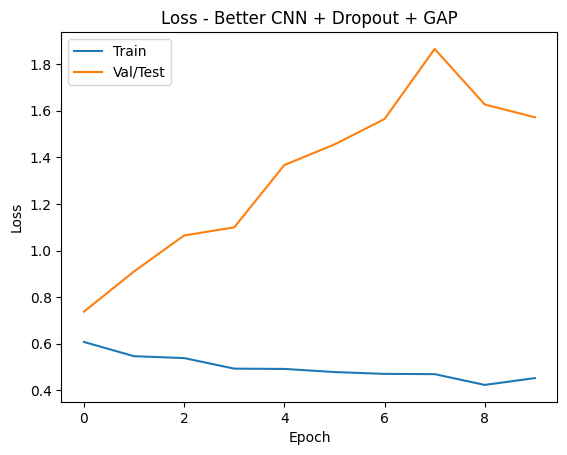

=== Exercice 4 (nouvelle CNN) ===
val_acc=0.5000  val_loss=1.5720


In [10]:
def build_better_cnn(num_classes: int):
    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    x = tf.keras.layers.Conv2D(32, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

better = build_better_cnn(train_gen_aug.num_classes)
better.summary()

hist_better, acc_better, loss_better = train_and_plot(
    better,
    train_gen_aug,   # on entraîne avec augmentation (recommandé)
    val_gen,
    "Better CNN + Dropout + GAP"
)

print("=== Exercice 4 (nouvelle CNN) ===")
print(f"val_acc={acc_better:.4f}  val_loss={loss_better:.4f}")


5- Classification en niveaux de ***gris***

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,442 (427.51 KB)

 Trainable params: 109,442 (427.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5441 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6777
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6230 - loss: 0.6600 - val_accuracy: 0.8300 - val_loss: 0.4813
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7559 - loss: 0.5681 - val_accuracy: 0.8600 - val_loss: 0.3899
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7342 - loss: 0.5425 - val_accuracy: 0.8400 - val_loss: 0.3922
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7373 - loss: 0.5554 - val_accuracy: 0.8500 - val_loss: 0.3481
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7553 - loss: 0.5075 - val_accuracy: 0.7100 - val_loss: 0.5518
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7440 - loss: 0.5479 - val_accuracy: 0.8100 - val_loss: 0.4065
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7541 - loss: 0.4861 - val_accuracy: 0.8600 - val_loss:

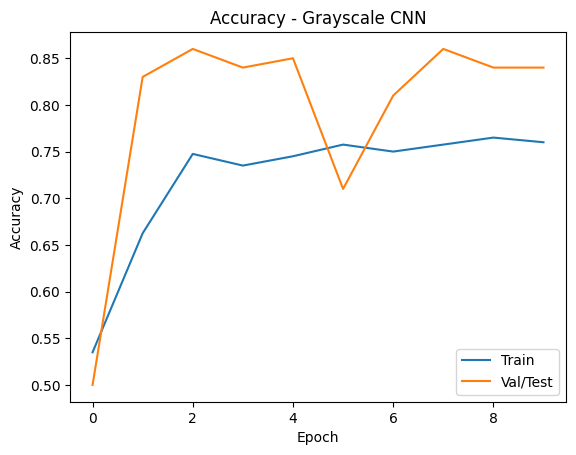

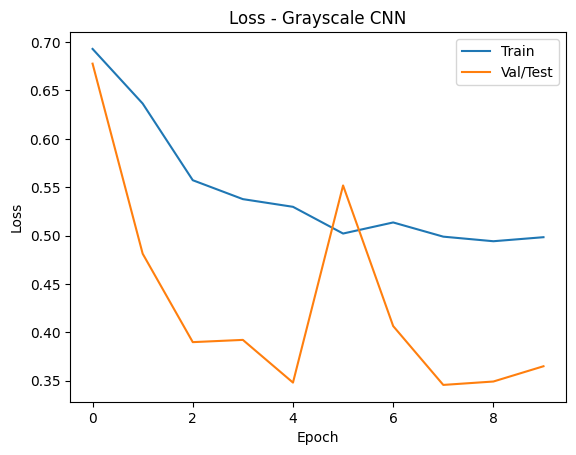

=== Exercice 5 (grayscale) ===
val_acc=0.8400  val_loss=0.3650


In [11]:
# Générateurs en niveaux de gris
train_datagen_gray = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen_gray = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen_gray = train_datagen_gray.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="grayscale",     # <-- IMPORTANT
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen_gray = val_datagen_gray.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="grayscale",     # <-- IMPORTANT
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Modèle pour grayscale
def build_gray_model(num_classes: int):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),  # <-- 1 canal

        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

gray_model = build_gray_model(train_gen_gray.num_classes)
gray_model.summary()

hist_gray, acc_gray, loss_gray = train_and_plot(gray_model, train_gen_gray, val_gen_gray, "Grayscale CNN")

print("=== Exercice 5 (grayscale) ===")
print(f"val_acc={acc_gray:.4f}  val_loss={loss_gray:.4f}")


In [12]:
def build_baseline_model(num_classes: int):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

baseline = build_baseline_model(train_gen_aug.num_classes)
baseline.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,690 (49.36 MB)

 Trainable params: 12,938,690 (49.36 MB)

 Non-trainable params: 0 (0.00 B)